# Tutorial 4 - Artificial Neural Networks

## Overview

Welcome to the Python Tutorial on Artificial Neural Networks (ANNs)! In this comprehensive guide, we will delve into one of the most powerful and versatile tools in machine learning, inspired by the structure and functioning of the human brain.

Artificial Neural Networks are a class of deep learning algorithms that excel at learning complex patterns and representations from data. ANNs have found applications in various domains, such as image and speech recognition, natural language processing, and recommendation systems.

In this tutorial, we will cover the fundamentals of Artificial Neural Networks, their architecture, and the mathematics behind their working. We will also explore different types of ANN architectures, such as feedforward networks and recurrent networks, and discuss their use cases.

## Prerequisites

Before diving into this tutorial, it is recommended to have a solid understanding of the following topics:

- Python programming fundamentals
- Basic concepts of machine learning, including supervised and unsupervised learning
- Linear algebra concepts, such as matrices and vectors
- Calculus, particularly derivatives

Knowledge of libraries like NumPy, scikit-learn and Pytorch will be beneficial.

## What You'll Learn

By the end of this tutorial, you will:

- Understand the structure and components of Artificial Neural Networks.
- Be familiar with different activation functions and how they affect the network's behavior.
- Learn about the forward and backward propagation algorithms used in training ANNs.
- Implement basic feedforward networks in Python.
- Explore advanced engineering topics, such as regularization techniques and optimization algorithms.
- Apply ANNs to real-world datasets and solve classification and regression problems.

## Problem Description

Consider the ridership of a public transportation system in the San Francisco
bay area, Bay Area Rapid Transit (BART). Recently, a group of researchers is
assuming that the ridership of the transit system is related to some
socio-economic factors, which are preliminarily the **total population near
each station, number of households that own 0 vehicles, total
employment, and total road network density**. The raw census data is
collected by the [Environment Protection Agency of the United States](https://www.epa.gov/sites/default/files/2021-06/documents/epa_sld_3.0_technicaldocumentationuserguide_may2021.pdf) while
the ridership data is available at the BART’s [official website](https://www.bart.gov/about/reports/ridership). The data for the
catchment area for each station is processed by Github user [HaTT2018](https://github.com/HaTT2018/BART_Ridership_Prediction).

To make this problem as simple as possible, we only investigate the ridership from station *Embarcadero* (the CBD of San Francisco) to other stations. (picture adopted from https://www.bart.gov/system-map)

<img title="Map of BART" src="./img/BART.png" width="800">

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import minmax_scale

In [11]:
# take the first 48 stations becasue the 
# last 2 stations were not yet opened
# by the time this data was collected
data_BART_sld = pd.read_csv('data_X.csv').iloc[:48, 1:]
data_BART_sld.head()

,TotPop,AutoOwn0,TotEmp,Tot Rd Dens
0,11084,1664,33120,42.232657
1,142973,20505,103479,32.296762
2,36177,4704,47570,31.822631
3,104191,8018,39663,32.894203
4,70630,1142,13924,20.531431


In [12]:
# The file "3d_daily.npy" contains the daily ridership
# data from each station to all the other stations.
# Its shape is [50, 50, 365]. Each dimension represents
# origin, destination, day in the year respectively

# Embarcadero is the 18th station in the list
OD_BART = np.load('3d_daily.npy').sum(axis=2)[17, :48]

In [13]:
print('Shape of data_BART_sld', data_BART_sld.shape)
print('Shape of OD_BART', OD_BART.shape)

Shape of data_BART_sld (48, 4)
Shape of OD_BART (48,)


## The model layout

Our job is to train an MLP model which takes "data_BART_sld" as input and generate "OD_BART" as output and make it as close to the real data as possible.

Consider a simple MLP, with 1 input layer, 1 hidden layer, and 1 output layer. The input layer has a dimension of 4 because we have 4 attributes of the scio-economic census. The output layer is 1-dimensional because the ridership is a scalar. The number of dimension of the hidden layer is set to be 2 for the sake of simplicity. The activation function is Sigmoid function as introduced in the lecture.

<img src="./img/MLP_demo.png" width="500">

## Using PyTorch

In [ ]:
%pip install torch
%pip install torchvision
%pip install torchinfo

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset
from torchvision import datasets
from sklearn.metrics import mean_absolute_error, r2_score

### Define a network
The structure used here is called "class", you can consider it as an object, here it is a network.

In [ ]:
# Model specification
class Simple_Network(nn.Module):
    def __init__(self, inp_dim, hid_dim, out_dim):
        """
        Initializes the neural network architecture.

        Parameters:
        inp_dim (int): The dimensionality of the input layer.
        out_dim (int): The dimensionality of the output layer.
        """
        super(Simple_Network, self).__init__()
        self.input_layer = nn.Linear(inp_dim, hid_dim)
        self.activation_function = nn.Sigmoid()
        self.output_layer = nn.Linear(hid_dim, out_dim)
        
    def forward(self, x):
        # x is the input data
        h = self.input_layer(x)  # h represents for the output for hidden layer
        h = self.activation_function(h)
        y = self.output_layer(h)  # y is the output data
        return y

### Prepare data
We divide the original data into two parts, 70% for training and 30% for model validation. Thus, the first 33 samples are for training, and the rest of the samples are for validation.

In [43]:
# I'm copying the data definition here
X_train = minmax_scale(data_BART_sld)[:33, :]
y_train = minmax_scale(OD_BART)[:33].reshape(-1, 1)
X_val = minmax_scale(data_BART_sld)[33:, :]
y_val = minmax_scale(OD_BART)[33:].reshape(-1, 1)

In [44]:
# this line returns the device that you are going to use
# if cuda is successfully installed, it will return "cuda"
# otherwise, "cpu"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X_train = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

# minibatch training, useful for big data, not useful here but I'm showing how to do this
# to realize full batch training, simply set this value to be very large
batch_size = 100  
loader_train = torch.utils.data.DataLoader(
    TensorDataset(X_train, y_train), batch_size, shuffle=True
)
iter_train = iter(loader_train)

### Train

In [45]:
# define the model and loss function
## you can play with different model specifications here!
## think about what part of the model you are modifying.
inp_dim = 4
hid_dim = 2
out_dim = 1

model = Simple_Network(inp_dim, hid_dim, out_dim).to(device)
loss_func = nn.MSELoss()

train_loss_torch = []
val_loss_torch = []

optimizer = optim.SGD(model.parameters(), lr=0.01)  # lr refers to learning rate

In [46]:
# the model specification
summary(model, (1, 4))

Layer (type:depth-idx)                   Output Shape              Param #
Simple_Network                           --                        --
├─Linear: 1-1                            [1, 2]                    10
├─Sigmoid: 1-2                           [1, 2]                    --
├─Linear: 1-3                            [1, 1]                    3
Total params: 13
Trainable params: 13
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00

In [47]:
model.train()
epochs = 200

for e in range(epochs):
    for i in range(len(loader_train)):
        # obtian X and y from the dataloader
        try:
            X, y = next(iter_train)
        except:
            iter_train = iter(loader_train)
            X, y = next(iter_train)
        
        out = model(X)  # forward propagation
        loss = loss_func(out, y)  # training loss

        out_val = model(X_val)
        loss_val = loss_func(out_val, y_val)  # validation loss


        # calculate  MAE and R²
        train_mae = mean_absolute_error(y.cpu().detach().numpy(), out.cpu().detach().numpy())
        val_mae = mean_absolute_error(y_val.cpu().detach().numpy(), out_val.cpu().detach().numpy())

        train_r2 = r2_score(y.cpu().detach().numpy(), out.cpu().detach().numpy())
        val_r2 = r2_score(y_val.cpu().detach().numpy(), out_val.cpu().detach().numpy())


        optimizer.zero_grad()
        loss.backward()  # backward propagation
        optimizer.step()  # update

        val_loss_torch.append(loss_val.cpu().detach().numpy())
        train_loss_torch.append(loss.cpu().detach().numpy())
    if e%50==0:
        print('Epoch %i   success, val loss:%.6f, train loss:%.6f,train mae:%.6f,val mae loss:%.6f,train r2:%.6f,val r2:%.6f'%(
            e, loss_val.cpu().detach().numpy(), loss.cpu().detach().numpy(),train_mae,val_mae,train_r2, val_r2 
        ))
        

Epoch 0   success, val loss:1.778377, train loss:1.954949,train mae:1.379214,val mae loss:1.318448,train r2:-34.820870,val r2:-43.383358
Epoch 50   success, val loss:0.130610, train loss:0.186022,train mae:0.368118,val mae loss:0.300917,train r2:-2.408516,val r2:-2.259675
Epoch 100   success, val loss:0.041309, train loss:0.063907,train mae:0.200277,val mae loss:0.143183,train r2:-0.170980,val r2:-0.030961
Epoch 150   success, val loss:0.041414, train loss:0.055034,train mae:0.187907,val mae loss:0.158243,train r2:-0.008401,val r2:-0.033567


### Visualize the loss

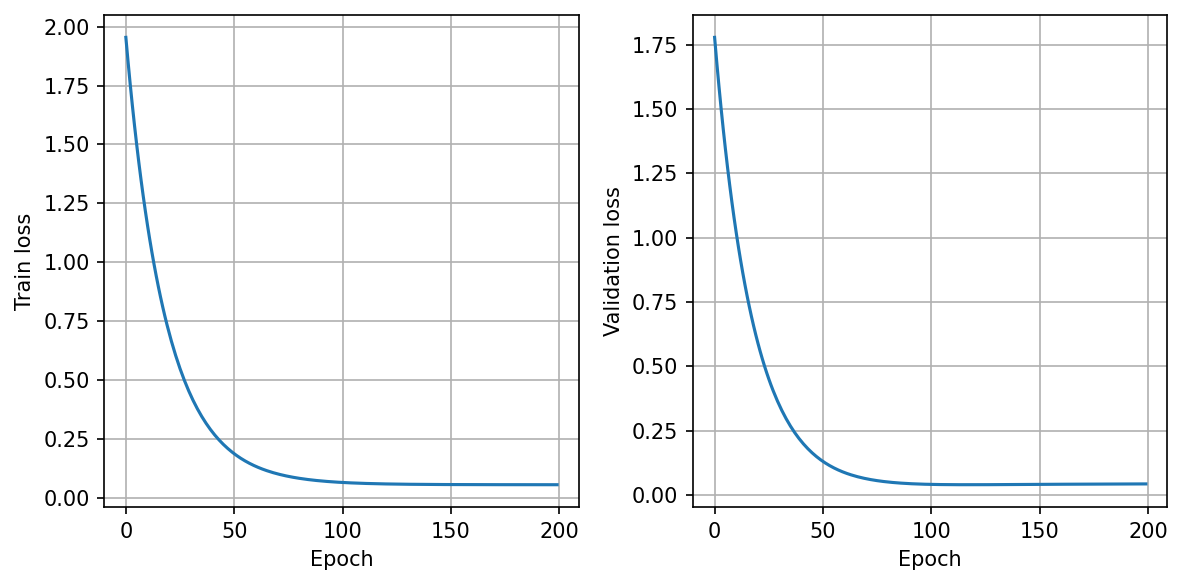

In [48]:
fig = plt.figure(figsize=[8, 4], dpi=150)
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(train_loss_torch)
ax1.grid()
ax1.set_ylabel('Train loss')
ax1.set_xlabel('Epoch')

ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(val_loss_torch)
ax2.grid()
ax2.set_ylabel('Validation loss')
ax2.set_xlabel('Epoch')

plt.tight_layout()

### Visualize the result

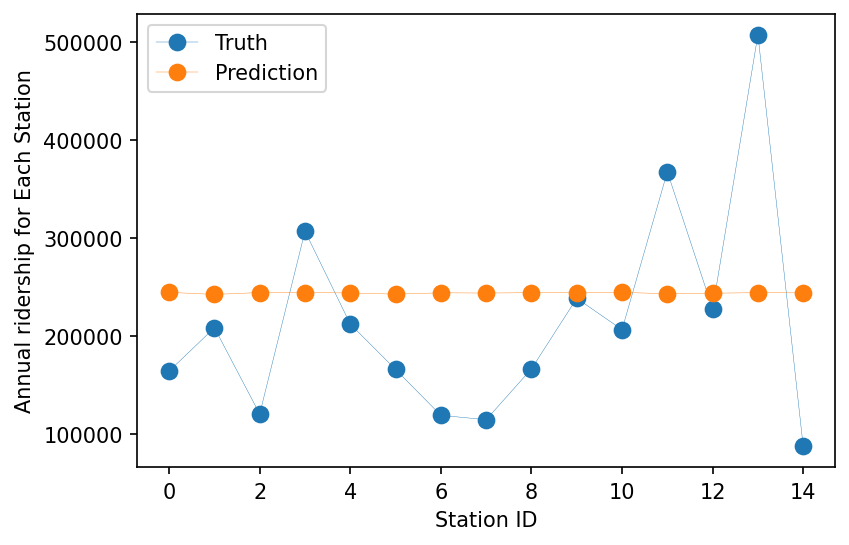

In [50]:
y_pred_torch = model(X_val).cpu().detach().numpy().flatten()
y_val_torch = y_val.cpu().detach().numpy().flatten()

plt.figure(dpi=150)
plt.plot(y_val_torch*(OD_BART.max() - OD_BART.min()) + OD_BART.min(), '.-', linewidth=0.2, markersize=15, label='Truth')
plt.plot(y_pred_torch*(OD_BART.max() - OD_BART.min()) + OD_BART.min(), '.-', linewidth=0.2, markersize=15, label='Prediction')
plt.xlabel("Station ID")
plt.ylabel("Annual ridership for Each Station")
plt.legend()

#### print the evaluation metrics

In [51]:
final_train_mae = mean_absolute_error(y_train.cpu().detach().numpy(), model(X_train).cpu().detach().numpy())
final_val_mae = mean_absolute_error(y_val.cpu().detach().numpy(), model(X_val).cpu().detach().numpy())

final_train_r2 = r2_score(y_train.cpu().detach().numpy(), model(X_train).cpu().detach().numpy())
final_val_r2 = r2_score(y_val.cpu().detach().numpy(), model(X_val).cpu().detach().numpy())

print("\nFinal Evaluation Metrics:")
print("Final Train MAE: %.6f" % final_train_mae)
print("Final Val MAE: %.6f" % final_val_mae)
print("Final Train R²: %.6f" % final_train_r2)
print("Final Val R²: %.6f" % final_val_r2)


Final Evaluation Metrics:
Final Train MAE: 0.188213
Final Val MAE: 0.168705
Final Train R²: 0.003572
Final Val R²: -0.078130


## Alignment between Layers
ANN has a high requirement for the alignment of input and output between layers. The number of output neurons in the previous layer should be STRICTLY EQUAL to the number of input neurons in the next layer.

For example, here we define an ANN model where `fc2` and `fc3` are not aligned

In [52]:
class UnalignedANN(nn.Module):
    def __init__(self):
        super(UnalignedANN, self).__init__()
        self.fc1 = nn.Linear(4, 8)
        self.fc2 = nn.Linear(8, 16)
        self.fc3 = nn.Linear(15, 32)  # Input should be 16 but we let it be 15 to show the error
        self.fc4 = nn.Linear(32, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)
        x = self.relu(x)
        x = self.fc4(x)
        return x

unalignedANN = UnalignedANN()

When we try to do the forward pass, misaligned layers will result in a RuntimeError about matrices that cannot be multiplied. You can try to modify the definition of fc3 to make it run normally. You can also remove the try-except part to see the specific Error type and location.

In [33]:
try:
    unalignedANN(torch.randn(1, 4))
except Exception as e:
    print("Find an Error!")
    print(f"The error message is: {e}")

Find an Error!
The error message is: mat1 and mat2 shapes cannot be multiplied (1x16 and 15x32)
